In [11]:
%matplotlib inline
#import ipywidgets as widgets
#from ipywidgets import interact
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from scipy.spatial.distance import cdist
#from numpy.linalg import inv
import george
from george.kernels import ExpSine2Kernel, ExpSquaredKernel
import astropy
from astropy.io import fits
import lightkurve
import theano
import theano.tensor as tt
import pymc3 as pm
from pymc3.step_methods.hmc import quadpotential
from scipy.signal import savgol_filter
#import exoplanet as xo

### 1) Load light curve data

In [12]:
filename = '/Users/chrislam/Desktop/epic-246301900/ktwo246301900-c12_llc.fits'
hdul = fits.open(filename)
hdul.info()

Filename: /Users/chrislam/Desktop/epic-246301900/ktwo246301900-c12_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   3862R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (10, 8)   int32   


In [13]:
data = fits.getdata(filename,header=True,ext=1)
df = pd.DataFrame(np.array(data[0]).byteswap().newbyteorder()) # to avoid big-endian/little-endian mixup: https://stackoverflow.com/questions/30283836/creating-pandas-dataframe-from-numpy-array-leads-to-strange-errors
print(df.head())

          TIME  TIMECORR  CADENCENO     SAP_FLUX  SAP_FLUX_ERR       SAP_BKG  \
0  2905.377230  0.005332     136855  614164.8125     22.716827  19529.195312   
1  2905.397662  0.005331     136856  614196.0000     22.708811  19530.005859   
2  2905.418095  0.005329     136857  614179.6250     22.713530  19541.736328   
3  2905.438527  0.005328     136858  614099.5000     22.717106  19533.994141   
4  2905.458959  0.005327     136859  614238.1875     22.723835  19532.445312   

   SAP_BKG_ERR  PDCSAP_FLUX  PDCSAP_FLUX_ERR  SAP_QUALITY  PSF_CENTR1  \
0     7.201994          NaN              NaN       524288         NaN   
1     7.175916  612915.2500        22.353420            0         NaN   
2     7.180060  612892.8125        22.366695            0         NaN   
3     7.191803  612824.8125        22.378389            0         NaN   
4     7.191343  612975.3750        22.391329            0         NaN   

   PSF_CENTR1_ERR  PSF_CENTR2  PSF_CENTR2_ERR  MOM_CENTR1  MOM_CENTR1_ERR  \
0  

3255


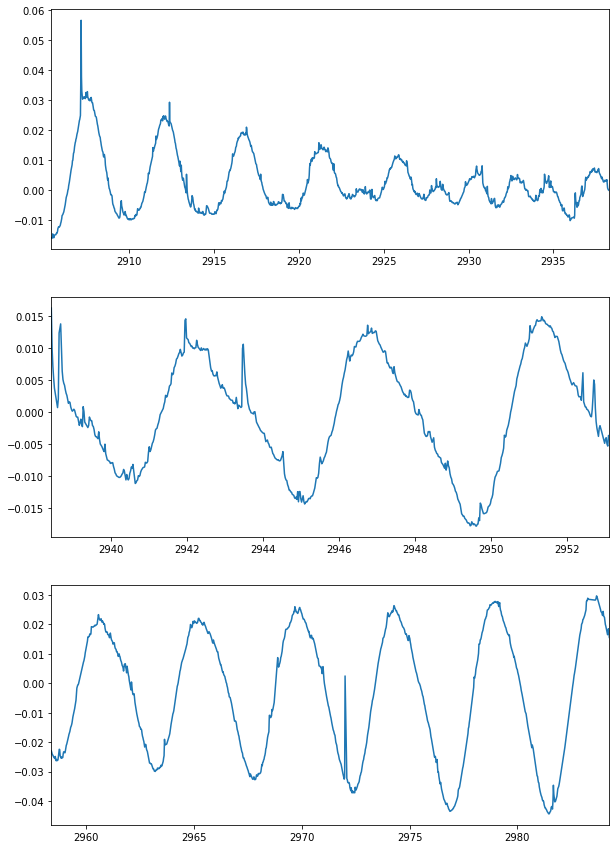

In [14]:
# divide data into pre-flare, post-flare/pre-gap, and post-flare/post-gap
df = pd.DataFrame(np.array(data[0]).byteswap().newbyteorder())
df = df.dropna(subset=['TIME','PDCSAP_FLUX','PDCSAP_FLUX_ERR']) # toss NaNs since they'll create matrices of NaNs
print(len(df))

pre = df.loc[:1611] # next record is the beginning of the flare, so stop here
post = df.loc[1614:2336] # start from after the flare until beginning of the gap in time series data
postgap = df.loc[2337:] # start from end of the gap in data until end of time series data
df_sans_superflare = pd.concat([pre, post, postgap])

plt.figure(figsize=(10,15))
plt.subplot(311)
xobs = np.array(pre["TIME"])
yobs = np.array(pre["PDCSAP_FLUX"])
plt.xlim(min(pre.TIME),max(pre.TIME))
#plt.ylim(590000,660000)
plt.plot(xobs,yobs/np.median(yobs)-1)

plt.subplot(312)
xobs = np.array(post["TIME"])
yobs = np.array(post["PDCSAP_FLUX"])
plt.xlim(min(post.TIME),max(post.TIME))
#plt.ylim(590000,660000)
plt.plot(xobs,yobs/np.median(yobs)-1)

plt.subplot(313)
xobs = np.array(postgap["TIME"])
yobs = np.array(postgap["PDCSAP_FLUX"])
plt.xlim(min(postgap.TIME),max(postgap.TIME))
#plt.ylim(590000,660000)
plt.plot(xobs,yobs/np.median(yobs)-1)
plt.show()

### 2) Load identified flares

In [15]:
path = '/Users/chrislam/Desktop/epic-246301900/'
identified_flares = pd.read_csv(path+'injection-recovery/identified_flares.csv')
print(identified_flares)

flares_pre = identified_flares.loc[identified_flares.tpeak <= np.max(pre.TIME)]
flares_post = identified_flares.loc[(identified_flares.tpeak <= np.max(post.TIME)) & (identified_flares.tpeak > np.max(pre.TIME))]
flares_postgap = identified_flares.loc[identified_flares.tpeak > np.max(post.TIME)]

"""
tpeaks = identified_flares.tpeak
ampls = identified_flares.ampls
fwhms = identified_flares.fwhms
npeaks = len(identified_flares)
"""
tpeaks = flares_pre.fixed_tpeaks
ampls = flares_pre.unnorm_ampls
fwhms = flares_pre.fwhms
flares_pre['fwhms_fixed_normed'] = (flares_pre.fixed_fwhms/1800)*2/1440
#fwhms = flares_pre.fixed_fwhms_normed
npeaks = len(flares_pre)

preds = pd.read_csv(path+'injection-recovery/preds.csv')
print(preds)
preds_pre = preds.loc[:len(pre)-1]
preds_post = preds.loc[len(pre)+1:len(pre)+len(post)]
preds_postgap = preds.loc[len(pre)+len(post):]

"""
x = df_sans_superflare.TIME
norm_flux = df.PDCSAP_FLUX/np.median(df.PDCSAP_FLUX) - 1
print(norm_flux)
y = (norm_flux-preds.flux_norm)/np.std(norm_flux-preds.flux_norm) # subtract out GP-modeled spot modulation flux
print(y)
"""
x = pre.TIME
norm_flux = pre.PDCSAP_FLUX/np.median(pre.PDCSAP_FLUX) - 1
#print(len(norm_flux), len(preds_pre), len(np.array(norm_flux)-np.array(preds_pre.flux_norm)),norm_flux-preds_pre.flux_norm)
y_std = (np.array(norm_flux)-np.array(preds_pre.flux_norm))/np.std(np.array(norm_flux)-np.array(preds_pre.flux_norm)) # subtract out GP-modeled spot modulation flux
y = np.array(norm_flux)-np.array(preds_pre.flux_norm) # subtract out GP-modeled spot modulation flux
print(y)
print(len(x), len(y))

    index        tpeak  tpeaks_norm     ampls  unnorm_ampls     fwhms  \
0       0  2905.826740   -16.018609  1.458995      0.002152  0.002778   
1       1  2907.134405   -14.710944  6.983271      0.010299  0.009722   
2       3  2907.440889   -14.404460  1.451282      0.002140  0.002778   
3       6  2909.504541   -12.340807  3.145568      0.004639  0.009722   
4       7  2909.749727   -12.095621  1.689845      0.002492  0.002778   
..    ...          ...          ...       ...           ...       ...   
62     16  2975.008522     3.687865  1.603894      0.002026  0.002778   
63     17  2976.275283     4.954627  2.286708      0.002888  0.002778   
64     18  2977.991542     6.670886  1.682145      0.002124  0.002778   
65     20  2979.176580     7.855923  1.439159      0.001818  0.002778   
66     22  2981.669248    10.348591  4.987364      0.006299  0.004167   

    fixed_tpeaks  fixed_fwhms   left_bases  right_bases  
0    2905.826740  4933.966329  2905.745011  2905.908470  
1    29

/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_2808/1698819553.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flares_pre['fwhms_fixed_normed'] = (flares_pre.fixed_fwhms/1800)*2/1440


In [16]:
flares_pre

,index,tpeak,tpeaks_norm,ampls,unnorm_ampls,fwhms,fixed_tpeaks,fixed_fwhms,left_bases,right_bases,fwhms_fixed_normed
0,0,2905.826740,-16.018609,1.458995,0.002152,0.002778,2905.826740,4933.966329,2905.745011,2905.908470,0.003807
1,1,2907.134405,-14.710944,6.983271,0.010299,0.009722,2907.154837,2434.243103,2907.073108,2907.216134,0.001878
2,3,2907.440889,-14.404460,1.451282,0.002140,0.002778,2907.440889,2043.730221,2907.400024,2907.502185,0.001577
3,6,2909.504541,-12.340807,3.145568,0.004639,0.009722,2909.524974,3474.035794,2909.422813,2909.586270,0.002681
4,7,2909.749727,-12.095621,1.689845,0.002492,0.002778,2909.749727,2767.661799,2909.688431,2909.831456,0.002136
5,8,2911.384300,-10.461049,1.598857,0.002358,0.002778,2911.384300,2097.050195,2911.363867,2911.466028,0.001618
6,9,2912.365041,-9.480308,5.201829,0.007672,0.002778,2912.365041,1637.193220,2912.344609,2912.405905,0.001263
7,10,2913.366214,-8.479135,3.355159,0.004948,0.002778,2913.366214,1997.054116,2913.345782,2913.447942,0.001541
8,11,2913.693127,-8.152222,1.664148,0.002454,0.005556,2913.693127,6110.837814,2913.611399,2913.774855,0.004715
9,12,2914.551273,-7.294075,1.996395,0.002944,0.002778,2914.551273,2391.655144,2914.469545,2914.612570,0.001845


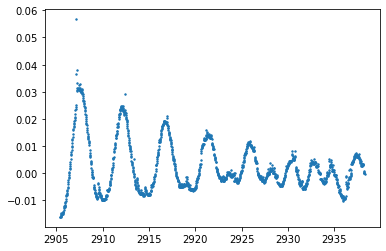

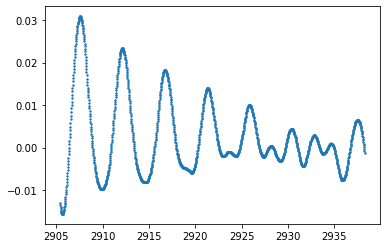

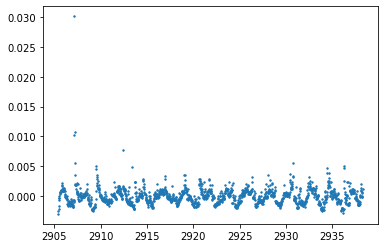

In [17]:
plt.scatter(x, norm_flux, s=2)
plt.show()

plt.scatter(x, np.array(preds_pre.flux_norm), s=2)
plt.show()

plt.scatter(x, y, s=2)
plt.show()

In [18]:
print(len(preds))
print(len(preds_pre)+len(preds_post)+len(preds_postgap))
print(len(pre)+len(post)+len(postgap))
print(len(preds_pre), len(preds_post), len(preds_postgap))
print(len(pre), len(post), len(postgap))
print(len(preds.loc[:len(pre)-1]), len(preds.loc[len(pre)+1:len(pre)+len(post)]),
     len(preds.loc[len(pre)+len(post):]))

3253
3253
3253
1511 671 1071
1511 671 1071
1511 671 1071


In [19]:
print(len(df))

3255


### 3) Run flare models based on xoflares

Ripped off completely from Tom Barclay's xoflares: https://github.com/mrtommyb/xoflares

In [20]:
# this is the flare model implemented in theano
def get_light_curve(time, tpeaks, fwhms, ampls, texp=None, oversample=7):
    time = time.astype('float64')
    time = tt.as_tensor_variable(time)
    
    if texp is None:
        tgrid = time
    if texp is not None:
        # taking this oversample code from
        # https://github.com/dfm/exoplanet
        # and https://github.com/lkreidberg/batman
        oversample = int(oversample)
        oversample += 1 - oversample % 2
        dt = np.linspace(-texp / 2., texp / 2.,
                         oversample)
        tgrid = tt.shape_padright(time) + dt
        
    multiflare_lc = multiflaremodel(tgrid, tpeaks, fwhms, ampls)
    
    if texp is not None:
        multiflare_lc = tt.mean(tt.reshape(multiflare_lc, (-1, oversample)),
            axis=1)

    return multiflare_lc

def multiflaremodel(t, tpeaks, fwhms, ampls):
    t = t.astype('float64')
    t = tt.as_tensor_variable(t)
    multiflare_lc = tt.zeros_like(t)
    flare_lc = tt.zeros_like(t)
    
    def scan_func(tpeak, fwhm, ampl):
        zeropad_flare_lc = tt.zeros_like(t)
        tcut = (((t - tpeak)/fwhm > -1.) * ((t - tpeak)/fwhm < 20.)).nonzero()
        flare_lc = _flaremodel(t[tcut], tpeak, fwhm, ampl)
        zeropad_flare_lc = tt.set_subtensor(zeropad_flare_lc[tcut],  flare_lc)
        return zeropad_flare_lc
    
    components, updates = theano.scan(fn=scan_func,
                                      sequences=[tpeaks, fwhms, ampls],
                                      )
    multiflare_lc = tt.sum(components, axis=0)
    
#     for i in range(npeaks):
#         tcut = (((t - tpeaks[i])/fwhms[i] > -1.) * ((t - tpeaks[i])/fwhms[i] < 20.)).nonzero()
#         flare_lc = _flaremodel(t[tcut], tpeaks[i], fwhms[i], ampls[i])
#         multiflare_lc = tt.set_subtensor(multiflare_lc[tcut],  multiflare_lc[tcut] + flare_lc)
    return multiflare_lc

def _flaremodel(t, tpeak, fwhm, ampl):
    # reuses some code from AltaiPony and Apaloosa
    t = tt.as_tensor_variable(t)
    flare_lc = tt.zeros_like(t)
    flare_lc = tt.where((t <= tpeak) * ((t - tpeak)/fwhm > -1.),
                        before_flare(t, tpeak, fwhm, ampl),
                        flare_lc
                       )
    flare_lc = tt.where((t > tpeak) * ((t - tpeak)/fwhm < 20.),
                        after_flare(t, tpeak, fwhm, ampl),
                        flare_lc
                       )
    return flare_lc

def before_flare(t, tpeak, fwhm, ampl):
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    fout = ((_fr[0] + _fr[1] * ((t - tpeak) / fwhm) +
                        _fr[2] * ((t - tpeak) / fwhm)**2. +
                        _fr[3] * ((t - tpeak) / fwhm)**3. +
                        _fr[4] * ((t - tpeak) / fwhm)**4. ) *
                        ampl)
    return fout

def after_flare(t, tpeak, fwhm, ampl):
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]
    fout = ((_fd[0] * tt.exp( ((t - tpeak) / fwhm) * _fd[1]) +
             _fd[2] * tt.exp( ((t - tpeak) / fwhm) * _fd[3] )) *
            ampl)
    return fout

xx = tt.dvector('xx')
tpeaksx = tt.dvector('tpeaksx')
fwhmsx = tt.dvector('fwhmsx')
amplsx = tt.dvector('amplsx')
#texp = 0.001388888888888889
#multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
#                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx, texp=texp))
theano.config.compute_test_value = 'ignore'

multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx))

In [108]:
np.log10(np.var(y))

-5.6624906235403865

Maybe oversampling will help? But I don't know what texp should be. So I rip off a random star's texp from the xoflares-real-star.ipynb notebook: https://github.com/mrtommyb/xoflares/blob/master/notebooks/xoflares-real-star.ipynb

In [ ]:
"""
# make a light curve
tpf = lightkurve.search_targetpixelfile('LTT 1445').download()
pix_mask = tpf.create_threshold_mask(threshold=2)
corrector = lightkurve.PLDCorrector(tpf)
lc = corrector.correct(aperture_mask=pix_mask,
                       cadence_mask=None,
                       use_gp=False)
lc.flux = lc.flux  * 1e3
texp = tpf.hdu[1].header['FRAMETIM'] * tpf.hdu[1].header["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
print(texp)
"""

I have entered dependency hell (potentially need to downgrade numpy version), so never mind.

In [21]:
# make a fine grid that spans the observation window for plotting purposes
t_plot = np.linspace(x.min(), x.max(), 10000)

with pm.Model() as model:
    npeaks = np.shape(tpeaks)[0]
    mean = pm.Normal("mean", mu=0, sd=3.0)
    logs2 = pm.Normal("logs2", mu=np.log10(np.var(y)), sd=1.0) # it'd be much smaller if it were natural log like I used to do
    
    tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.003, shape=npeaks) # was *0.003
    logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=1.0, shape=npeaks)
    logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=1.0, shape=npeaks)
    
    fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
    ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
    
    #flare_lc = get_light_curve(x, tpeak, fwhm, ampl, texp=texp, oversample=15)
    flare_lc = get_light_curve(x, tpeak, fwhm, ampl, oversample=15)
    #flare_lc_pred = get_light_curve(t_plot, tpeak, fwhm, ampl, oversample=7) # this one's for plotting only
    pm.Deterministic("flare_lc", flare_lc)
    #pm.Deterministic("flare_lc_pred", flare_lc_pred) # this one's for plotting only
    pm.Normal("obs", mu=flare_lc + mean, sd=tt.exp(2*logs2), observed=y) # previously was 2*logs2
    
    #map_soln = xo.optimize(start=model.test_point, vars=[1/fwhm, mean])
    #map_soln = xo.optimize(start=map_soln, vars=[1/ampl, mean])
    #map_soln = xo.optimize(start=map_soln, vars=[1/fwhm, 1/ampl])
    #map_soln = xo.optimize(start=map_soln, vars=[tpeak])
    
    approx = pm.MeanField()
    pm.fit(method=pm.KLqp(approx), n=1000000, 
            obj_optimizer=pm.adagrad_window
        )
    start = approx.sample(draws=8, )
    start = list(start)
    stds = approx.bij.rmap(approx.std.eval())
    cov = model.dict_to_array(stds) ** 2
    potential = quadpotential.QuadPotentialDiag(cov)

Finished [100%]: Average Loss = -8,229.5


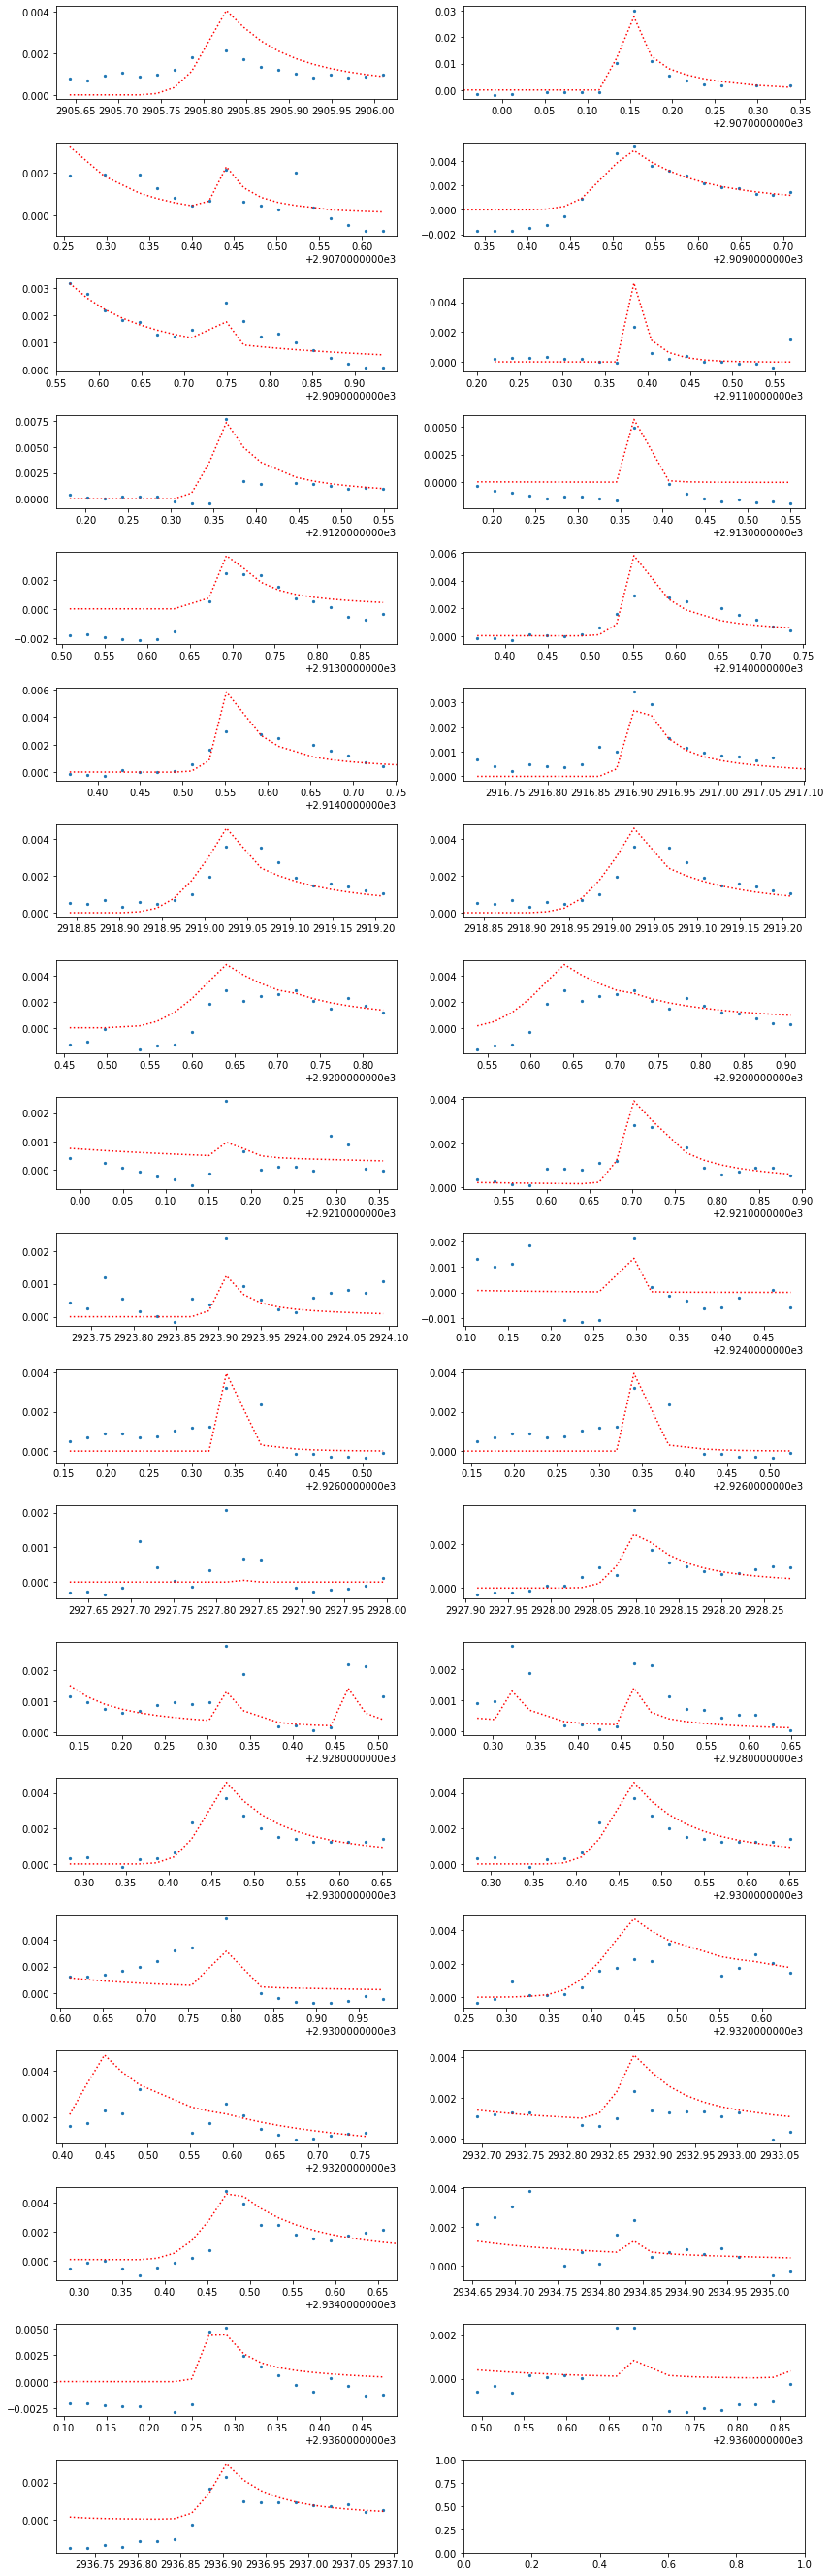

In [22]:
import warnings
warnings.filterwarnings("ignore")

fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
tps = start[0]['tpeak']
for i in range(npeaks):
    timemask = (x >= tps[i]-0.2) * (x < tps[i]+0.2) # true for values within +/- 0.2 of peak indices
    ax = axes[i]
    ax.scatter(x[timemask], y[timemask], s=5)
    ax.plot(x[timemask], start[0]['flare_lc'][timemask], ':r')
    #ax.scatter(tpeaks[i], ampls[i])
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    #ax.set_ylim(np.min(y[timemask]), np.max(y[timemask]))
fig.tight_layout()

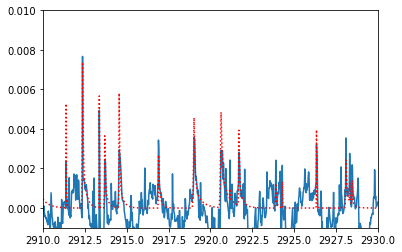

In [23]:
#fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
#axes = axes.flatten()
#tps = start[0]['tpeak']
plt.plot(x, y)
plt.plot(x, start[0]['flare_lc'], ':r')
plt.xlim(2910, 2930)
plt.ylim(-0.001, 0.01)
plt.show()

In [24]:
with model:
    step = pm.NUTS(potential=potential, target_accept=0.9)
    trace = pm.sample(draws=2400, tune=200, step=step, start=start, cores=8)

Multiprocess sampling (8 chains in 8 jobs)
NUTS: [logAmpl, logFwhm, tpeak, logs2, mean]


Sampling 8 chains for 200 tune and 2_400 draw iterations (1_600 + 19_200 draws total) took 6246 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


[]

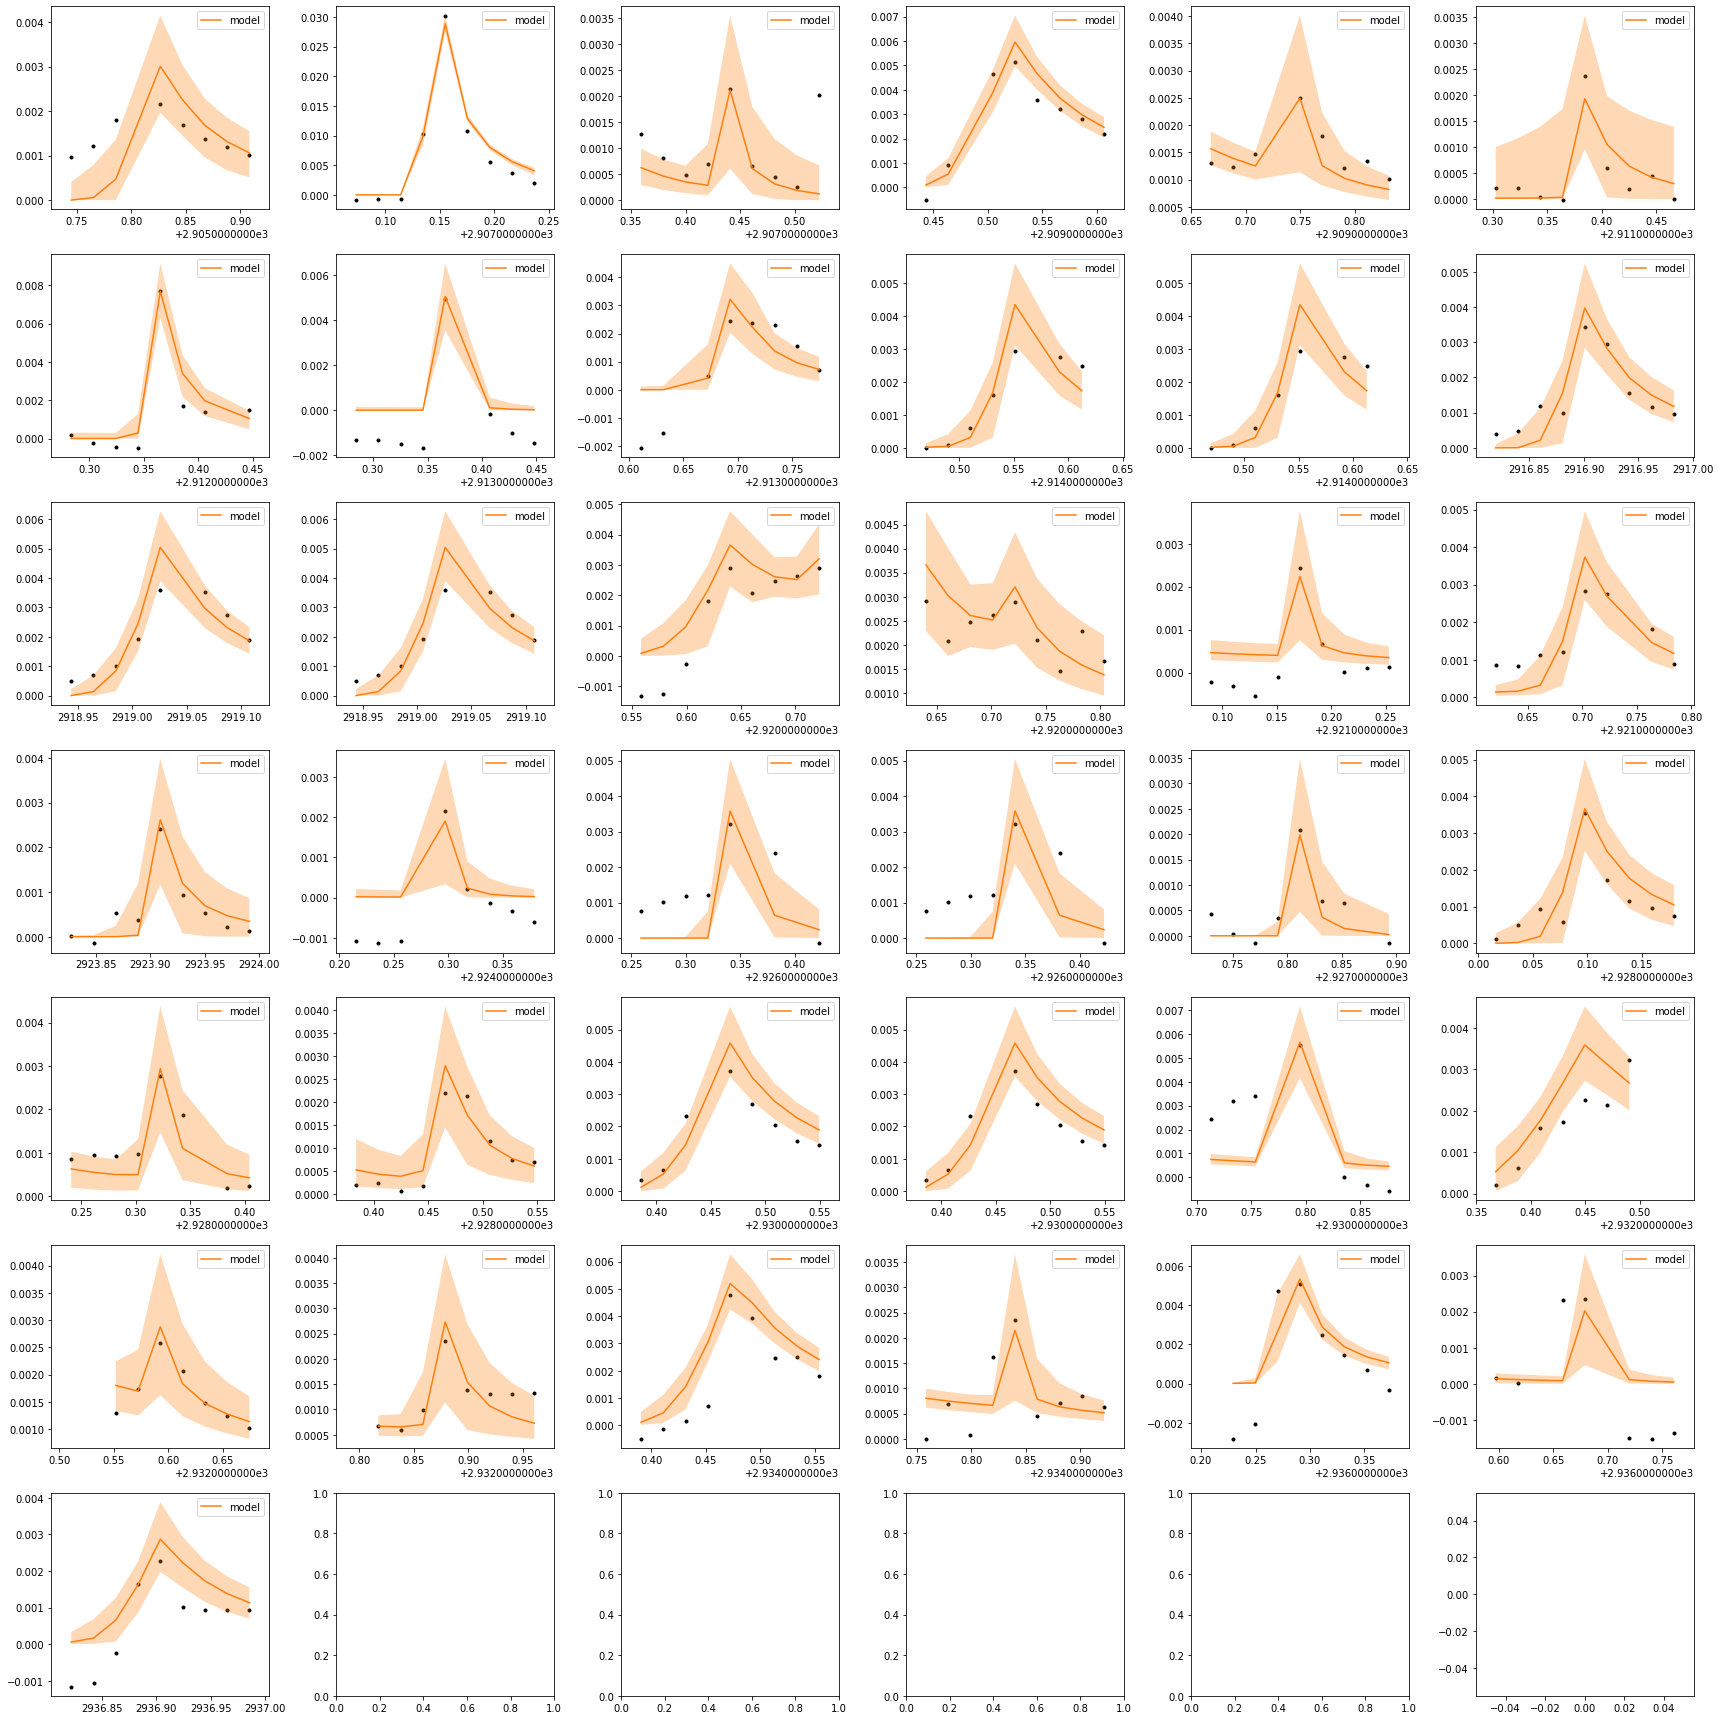

In [25]:
#flc_plot =  np.percentile(trace['flare_lc_pred'], [5, 50, 95], axis=0)
flc =  np.percentile(trace['flare_lc'], [5, 50, 95], axis=0)
fig, axes = plt.subplots(ncols=6, nrows=np.ceil(npeaks/6).astype(int), figsize=[24,24])
axes = axes.flatten()
for i in range(npeaks):
    #timemask_t_plot = (t_plot >= tpeaks[i]-0.1) * (t_plot < tpeaks[i]+0.1)
    timemask = (x >= tpeaks[i]-0.1) * (x < tpeaks[i]+0.1)
    ax = axes[i]
    ax.plot(x[timemask], y[timemask], '.k')
    ax.plot(x[timemask], flc[1][timemask], label="model", color="C1")
    art = ax.fill_between(x[timemask], 
                          flc[0][timemask],
                          flc[2][timemask], color="C1", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(tpeaks[i]-0.1, tpeaks[i]+0.1)
    #ax.set_ylim(np.min(y[timemask]) - 1, 1 + np.max(y[timemask]))
    ax.legend()

fig.tight_layout()
#fig.savefig('flare-model-pre.png')
plt.plot()

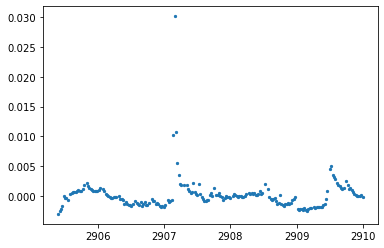

In [26]:
buffer = 0.2
buffer_idx = 8
timemask = (x >= tpeaks[0]-buffer) * (x < tpeaks[0]+buffer)
timemask = (x <= 2910)
plt.scatter(x[timemask], y[timemask], s=5)
plt.show()

tpeaks_test = tpeaks[0:buffer_idx]
npeaks_test = len(tpeaks_test)
x_test = x[timemask]
y_test = y[timemask]
fwhms_test = fwhms[0:buffer_idx]
ampls_test = ampls[0:buffer_idx]


In [ ]:
import corner

# for some reason, pymc wants to access trace at index 0 when trace starts at 1...so I cheat to make this work
#trace._straces[0] = trace._straces[1]
samples = pm.trace_to_dataframe(trace, varnames=['tpeak', 'ampl', 'fwhm'])
for i in range(trace['tpeak'].shape[1]):
    corner.corner(samples.loc[:,
                              ['tpeak__{}'.format(i), 'ampl__{}'.format(i),
                               'fwhm__{}'.format(i)]], truths=tpeaks);

In [168]:
samples

,tpeak__0,tpeak__1,tpeak__2,tpeak__3,tpeak__4,tpeak__5,tpeak__6,tpeak__7,tpeak__8,tpeak__9,...,fwhm__27,fwhm__28,fwhm__29,fwhm__30,fwhm__31,fwhm__32,fwhm__33,fwhm__34,fwhm__35,fwhm__36
0,2905.825610,2907.142796,2907.433819,2909.522526,2909.751976,2911.385412,2912.366912,2913.365010,2913.695158,2914.553922,...,0.139767,0.001586,0.170616,0.007796,0.040763,0.103654,0.000796,0.017504,0.004152,0.096335
1,2905.824320,2907.142763,2907.440054,2909.521619,2909.745362,2911.379418,2912.363103,2913.365614,2913.695108,2914.551746,...,0.127520,0.002378,0.143121,0.002630,0.036214,0.083882,0.006519,0.025452,0.001491,0.085729
2,2905.826788,2907.143336,2907.442571,2909.523445,2909.752819,2911.382296,2912.366000,2913.365181,2913.694749,2914.548807,...,0.122684,0.001703,0.205993,0.015943,0.046091,0.121841,0.001423,0.039662,0.009623,0.064769
3,2905.825227,2907.143560,2907.441976,2909.522666,2909.744707,2911.381033,2912.362615,2913.364143,2913.692726,2914.552199,...,0.108315,0.003340,0.198155,0.006169,0.007578,0.093194,0.010049,0.037751,0.003544,0.112858
4,2905.825820,2907.142990,2907.442890,2909.519794,2909.751627,2911.381194,2912.360854,2913.363858,2913.693263,2914.548773,...,0.112817,0.001817,0.164258,0.008421,0.003225,0.093538,0.001937,0.052712,0.005885,0.086856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19195,2905.829301,2907.143556,2907.445012,2909.525053,2909.746184,2911.381581,2912.362877,2913.366481,2913.697516,2914.555137,...,0.099854,0.007514,0.185490,0.013466,0.012930,0.122656,0.032523,0.024041,0.006995,0.072177
19196,2905.828869,2907.143392,2907.446220,2909.519428,2909.743653,2911.382690,2912.365714,2913.367128,2913.699386,2914.552886,...,0.113246,0.003714,0.168109,0.002641,0.012533,0.106635,0.007222,0.016760,0.004463,0.083827
19197,2905.825391,2907.143537,2907.436163,2909.526806,2909.755721,2911.385133,2912.360920,2913.365627,2913.698829,2914.551858,...,0.092771,0.002228,0.110099,0.023951,0.071514,0.076719,0.001787,0.017709,0.002503,0.052823
19198,2905.826983,2907.143650,2907.441886,2909.528571,2909.753768,2911.383391,2912.360199,2913.365747,2913.698240,2914.551557,...,0.097947,0.002371,0.094093,0.067528,0.042298,0.060226,0.002600,0.019190,0.002091,0.038399


### 3.5) Post and postgap chunks

post

In [27]:
tpeaks_post = flares_post.fixed_tpeaks
ampls_post = flares_post.unnorm_ampls
fwhms_post = flares_post.fwhms
flares_post['fwhms_fixed_normed'] = (flares_post.fixed_fwhms/1800)*2/1440
#fwhms = flares_pre.fixed_fwhms_normed
npeaks_post = len(flares_post)

x_post = post.TIME
norm_flux_post = post.PDCSAP_FLUX/np.median(post.PDCSAP_FLUX) - 1
#print(len(norm_flux), len(preds_pre), len(np.array(norm_flux)-np.array(preds_pre.flux_norm)),norm_flux-preds_pre.flux_norm)
y_std_post = (np.array(norm_flux_post)-np.array(preds_post.flux_norm))/np.std(np.array(norm_flux_post)-np.array(preds_post.flux_norm)) # subtract out GP-modeled spot modulation flux
y_post = np.array(norm_flux_post)-np.array(preds_post.flux_norm) # subtract out GP-modeled spot modulation flux
#print(y_post)
print(len(x_post), len(y_post))

xx = tt.dvector('xx')
tpeaksx = tt.dvector('tpeaksx')
fwhmsx = tt.dvector('fwhmsx')
amplsx = tt.dvector('amplsx')
#texp = 0.001388888888888889
#multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
#                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx, texp=texp))
theano.config.compute_test_value = 'ignore'

multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx))

671 671


In [28]:
# make a fine grid that spans the observation window for plotting purposes
#t_plot = np.linspace(x.min(), x.max(), 10000)

with pm.Model() as model:
    npeaks = np.shape(tpeaks_post)[0]
    mean = pm.Normal("mean", mu=0, sd=3.0)
    logs2 = pm.Normal("logs2", mu=np.log10(np.var(y_post)), sd=1.0) # it'd be much smaller if it were natural log like I used to do
    
    tpeak = pm.Normal("tpeak", mu=tpeaks_post, sd=np.ones_like(tpeaks_post) * 0.003, shape=npeaks) 
    logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms_post), sd=1.0, shape=npeaks)
    logAmpl = pm.Normal("logAmpl", mu=np.log(ampls_post), sd=1.0, shape=npeaks)
    
    fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
    ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
    
    #flare_lc = get_light_curve(x, tpeak, fwhm, ampl, texp=texp, oversample=15)
    flare_lc = get_light_curve(x_post, tpeak, fwhm, ampl, oversample=15)
    #flare_lc_pred = get_light_curve(t_plot, tpeak, fwhm, ampl, oversample=7) # this one's for plotting only
    pm.Deterministic("flare_lc", flare_lc)
    #pm.Deterministic("flare_lc_pred", flare_lc_pred) # this one's for plotting only
    pm.Normal("obs", mu=flare_lc + mean, sd=tt.exp(2*logs2), observed=y_post) 
    
    #map_soln = xo.optimize(start=model.test_point, vars=[1/fwhm, mean])
    #map_soln = xo.optimize(start=map_soln, vars=[1/ampl, mean])
    #map_soln = xo.optimize(start=map_soln, vars=[1/fwhm, 1/ampl])
    #map_soln = xo.optimize(start=map_soln, vars=[tpeak])
    
    approx = pm.MeanField()
    pm.fit(method=pm.KLqp(approx), n=1000000, 
            obj_optimizer=pm.adagrad_window
        )
    start = approx.sample(draws=8, )
    start = list(start)
    stds = approx.bij.rmap(approx.std.eval())
    cov = model.dict_to_array(stds) ** 2
    potential = quadpotential.QuadPotentialDiag(cov)

Finished [100%]: Average Loss = -3,205.7


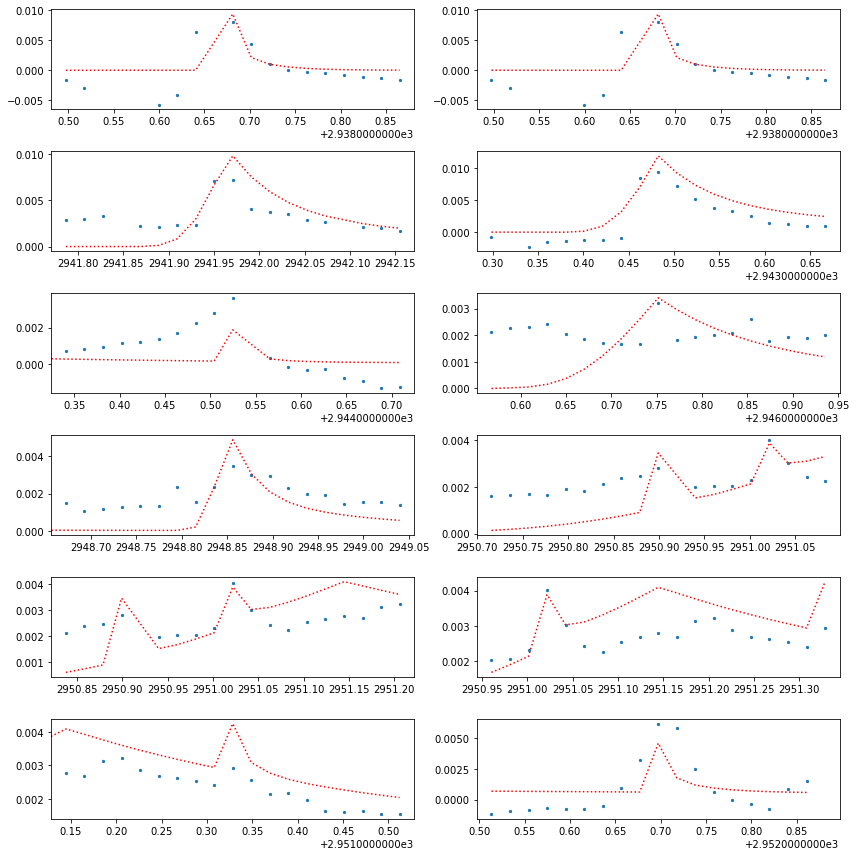

In [29]:
import warnings
warnings.filterwarnings("ignore")

fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
tps = start[0]['tpeak']
for i in range(npeaks):
    timemask = (x_post >= tps[i]-0.2) * (x_post < tps[i]+0.2) # true for values within +/- 0.2 of peak indices
    ax = axes[i]
    ax.scatter(x_post[timemask], y_post[timemask], s=5)
    ax.plot(x_post[timemask], start[0]['flare_lc'][timemask], ':r')
    #ax.scatter(tpeaks[i], ampls[i])
    ax.set_xlim(np.array(tpeaks_post)[i]-0.2, np.array(tpeaks_post)[i]+0.2)
    #ax.set_ylim(np.min(y[timemask]), np.max(y[timemask]))
fig.tight_layout()

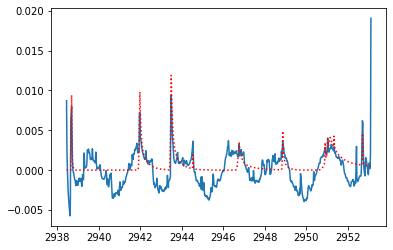

In [30]:
#fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
#axes = axes.flatten()
#tps = start[0]['tpeak']
plt.plot(x_post, y_post)
plt.plot(x_post, start[0]['flare_lc'], ':r')
plt.show()

In [31]:
with model:
    step = pm.NUTS(potential=potential, target_accept=0.9)
    trace = pm.sample(draws=2400, tune=200, step=step, start=start, cores=8)

Multiprocess sampling (8 chains in 8 jobs)
NUTS: [logAmpl, logFwhm, tpeak, logs2, mean]


Sampling 8 chains for 200 tune and 2_400 draw iterations (1_600 + 19_200 draws total) took 495 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


[]

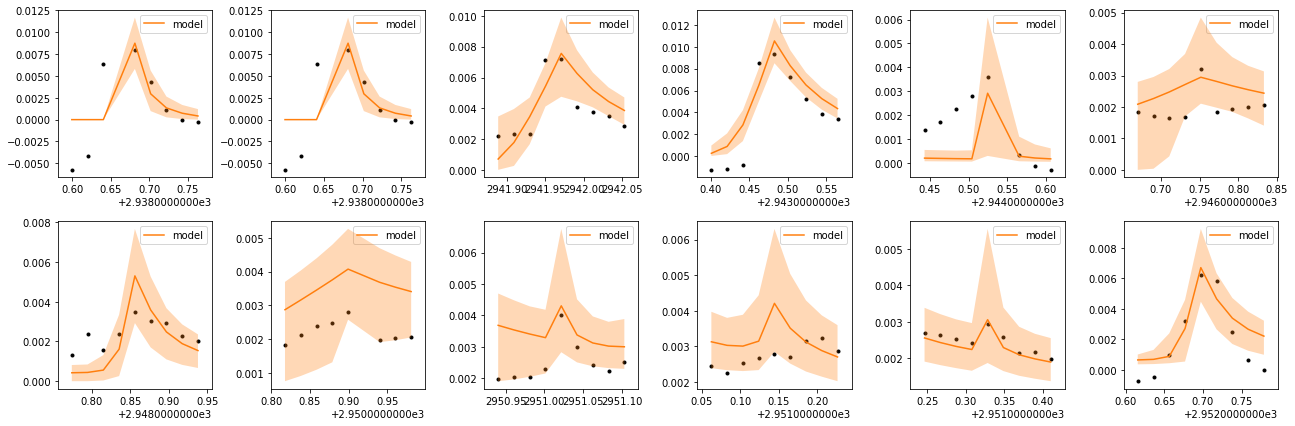

In [33]:
#flc_plot =  np.percentile(trace['flare_lc_pred'], [5, 50, 95], axis=0)
flc_post =  np.percentile(trace['flare_lc'], [5, 50, 95], axis=0)
fig, axes = plt.subplots(ncols=6, nrows=np.ceil(npeaks/6).astype(int), figsize=[18,6])
axes = axes.flatten()
for i in range(npeaks):
    #timemask_t_plot = (t_plot >= tpeaks[i]-0.1) * (t_plot < tpeaks[i]+0.1)
    timemask = (x_post >= np.array(tpeaks_post)[i]-0.1) * (x_post < np.array(tpeaks_post)[i]+0.1)
    ax = axes[i]
    ax.plot(x_post[timemask], y_post[timemask], '.k')
    ax.plot(x_post[timemask], flc_post[1][timemask], label="model", color="C1")
    art = ax.fill_between(x_post[timemask], 
                          flc_post[0][timemask],
                          flc_post[2][timemask], color="C1", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(np.array(np.array(tpeaks_post))[i]-0.1, np.array(tpeaks_post)[i]+0.1)
    #ax.set_ylim(np.min(y[timemask]) - 1, 1 + np.max(y[timemask]))
    ax.legend()

fig.tight_layout()
#fig.savefig('flare-model-post.png')
plt.plot()

postgap

In [34]:
tpeaks_postgap = flares_postgap.fixed_tpeaks
ampls_postgap = flares_postgap.unnorm_ampls
fwhms_postgap = flares_postgap.fwhms
flares_postgap['fwhms_fixed_normed'] = (flares_postgap.fixed_fwhms/1800)*2/1440
#fwhms = flares_pre.fixed_fwhms_normed
npeaks_postgap = len(flares_postgap)

x_postgap = postgap.TIME
norm_flux_postgap = postgap.PDCSAP_FLUX/np.median(postgap.PDCSAP_FLUX) - 1
#print(len(norm_flux), len(preds_pre), len(np.array(norm_flux)-np.array(preds_pre.flux_norm)),norm_flux-preds_pre.flux_norm)
y_std_postgap = (np.array(norm_flux_postgap)-np.array(preds_postgap.flux_norm))/np.std(np.array(norm_flux_postgap)-np.array(preds_postgap.flux_norm)) # subtract out GP-modeled spot modulation flux
y_postgap = np.array(norm_flux_postgap)-np.array(preds_postgap.flux_norm) # subtract out GP-modeled spot modulation flux
#print(y_post)
print(len(x_postgap), len(y_postgap))

xx = tt.dvector('xx')
tpeaksx = tt.dvector('tpeaksx')
fwhmsx = tt.dvector('fwhmsx')
amplsx = tt.dvector('amplsx')
#texp = 0.001388888888888889
#multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
#                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx, texp=texp))
theano.config.compute_test_value = 'ignore'

multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx))

1071 1071


In [35]:
# make a fine grid that spans the observation window for plotting purposes
#t_plot = np.linspace(x.min(), x.max(), 10000)

with pm.Model() as model:
    npeaks = np.shape(tpeaks_postgap)[0]
    mean = pm.Normal("mean", mu=0, sd=3.0)
    logs2 = pm.Normal("logs2", mu=np.log10(np.var(y_postgap)), sd=1.0) # it'd be much smaller if it were natural log like I used to do
    
    tpeak = pm.Normal("tpeak", mu=tpeaks_postgap, sd=np.ones_like(tpeaks_postgap) * 0.003, shape=npeaks) 
    logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms_postgap), sd=1.0, shape=npeaks)
    logAmpl = pm.Normal("logAmpl", mu=np.log(ampls_postgap), sd=1.0, shape=npeaks)
    
    fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
    ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
    
    #flare_lc = get_light_curve(x, tpeak, fwhm, ampl, texp=texp, oversample=15)
    flare_lc = get_light_curve(x_postgap, tpeak, fwhm, ampl, oversample=15)
    #flare_lc_pred = get_light_curve(t_plot, tpeak, fwhm, ampl, oversample=7) # this one's for plotting only
    pm.Deterministic("flare_lc", flare_lc)
    #pm.Deterministic("flare_lc_pred", flare_lc_pred) # this one's for plotting only
    pm.Normal("obs", mu=flare_lc + mean, sd=tt.exp(2*logs2), observed=y_postgap) 
    
    #map_soln = xo.optimize(start=model.test_point, vars=[1/fwhm, mean])
    #map_soln = xo.optimize(start=map_soln, vars=[1/ampl, mean])
    #map_soln = xo.optimize(start=map_soln, vars=[1/fwhm, 1/ampl])
    #map_soln = xo.optimize(start=map_soln, vars=[tpeak])
    
    approx = pm.MeanField()
    pm.fit(method=pm.KLqp(approx), n=1000000, 
            obj_optimizer=pm.adagrad_window
        )
    start = approx.sample(draws=8, )
    start = list(start)
    stds = approx.bij.rmap(approx.std.eval())
    cov = model.dict_to_array(stds) ** 2
    potential = quadpotential.QuadPotentialDiag(cov)
    

Finished [100%]: Average Loss = -6,182.4


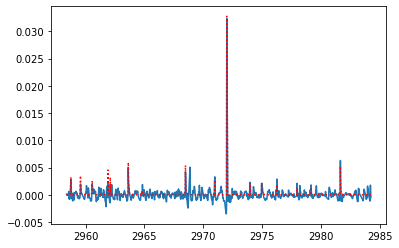

In [36]:
#fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
#axes = axes.flatten()
#tps = start[0]['tpeak']
plt.plot(x_postgap, y_postgap)
plt.plot(x_postgap, start[0]['flare_lc'], ':r')
plt.show()

In [37]:
with model:
    step = pm.NUTS(potential=potential, target_accept=0.9)
    trace = pm.sample(draws=2400, tune=200, step=step, start=start, cores=8)

Multiprocess sampling (8 chains in 8 jobs)
NUTS: [logAmpl, logFwhm, tpeak, logs2, mean]


Sampling 8 chains for 200 tune and 2_400 draw iterations (1_600 + 19_200 draws total) took 3298 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


[]

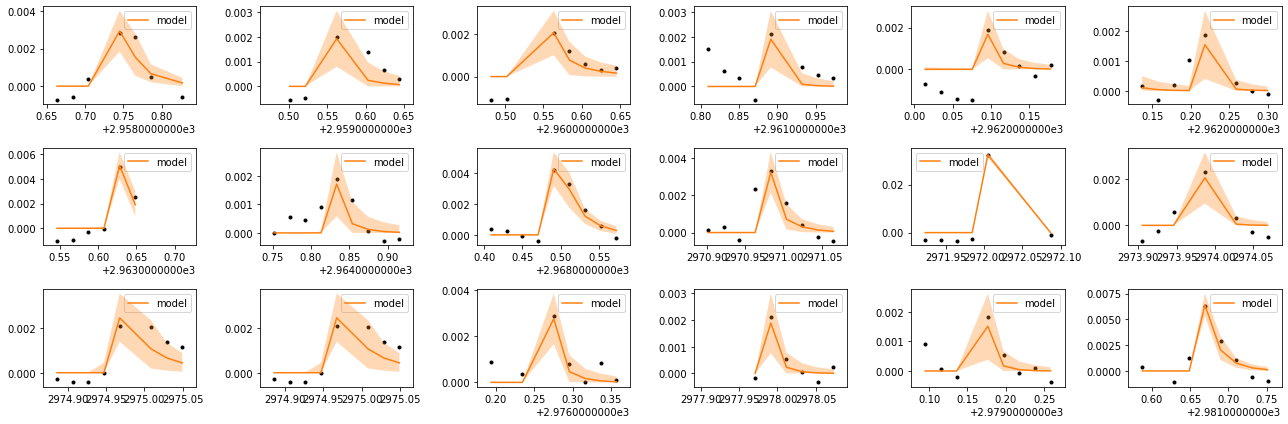

In [39]:
#flc_plot =  np.percentile(trace['flare_lc_pred'], [5, 50, 95], axis=0)
flc_postgap =  np.percentile(trace['flare_lc'], [5, 50, 95], axis=0)
fig, axes = plt.subplots(ncols=6, nrows=np.ceil(npeaks/6).astype(int), figsize=[18,6])
axes = axes.flatten()
for i in range(npeaks):
    #timemask_t_plot = (t_plot >= tpeaks[i]-0.1) * (t_plot < tpeaks[i]+0.1)
    timemask = (x_postgap >= np.array(tpeaks_postgap)[i]-0.1) * (x_postgap < np.array(tpeaks_postgap)[i]+0.1)
    ax = axes[i]
    ax.plot(x_postgap[timemask], y_postgap[timemask], '.k')
    ax.plot(x_postgap[timemask], flc_postgap[1][timemask], label="model", color="C1")
    art = ax.fill_between(x_postgap[timemask], 
                          flc_postgap[0][timemask],
                          flc_postgap[2][timemask], color="C1", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(np.array(np.array(tpeaks_postgap))[i]-0.1, np.array(tpeaks_postgap)[i]+0.1)
    #ax.set_ylim(np.min(y[timemask]) - 1, 1 + np.max(y[timemask]))
    ax.legend()

fig.tight_layout()
#fig.savefig('flare-model-postgap.png')
plt.plot()

### 4) Measuring flare energy

From Doyle et al 2018 "Investigating the rotational phase of stellar flares on M dwarfs using K2 short cadence data"

"To determine the energy of the stellar flares, the quiescent luminosity of the star, L_star, must be calculated in the Kepler bandpass. To construct a template spectral energy distribution for each star we used PanStarrs magnitudes g, r, i, and z (see Table A1). The PanStarrs magnitudes (Chambers et al. 2016) represent the mean quiescent magnitude of the star calculated over an average of multiple measurements. This ensures the effects of flares or rotation has been removed from the magnitudes. We fitted a polynomial to the Panstarrs data and determined the flux in the Keplerbandpass in the same manner as Kowalski et al. (2013). The quiescent luminosity is then computed by multiplying the flux by 4πd2, where the distance (d) to the stars has been determined by inverting the parallax from the Gaia Data 2 release (Gaia Collaboration et al. 2016, 2018; see Table 3)...The energy of the flares, Eflare, can then be determined by the multiplication of the luminosity of the star, L*, in erg s−1 and the equivalent duration, t, in seconds. The equivalent duration (Gershberg 1972) is defined as the area under the flare light curve in units of seconds"

OR, from Davenport 2016 "THE KEPLER CATALOG OF STELLAR FLARES": 

"For this reason it better to not assume a single flare spectrum, and instead I estimate the distance and luminosity for each star to determine it’s quiescent luminosity. The Kepler Input Catalog provides ground-based photometry for all available stars in the Kepler field of view. Using Version 10 of this catalog , I obtained the g, Ks, and Kp (Kepler) photometry for every star in the sample. The g − Ks color is then used to place each star on to a stellar isochrone model, which gives an absolute magnitude and mass for each star. Typical photometric uncertainties from the g − Ks color propagate to mass uncertainties of ∼0.02 M_star. This assumes that all stars in the sample are on the isochrone’s main sequence. A 1- Gyr isochrone from the PARSEC models (Bressan et al. 2012) with Z=0.019 and no dust extinction is used. Note this will yield an incorrect distance for giant and subgiant stars. The star’s absolute g, Ks, and Kp (Kepler) magnitudes are determined by linearly interpolating the observed g − K color to the gridded values from the isochrone. The apparent Ks magnitude for each star is used to determine the distance modulus. The isochronederived absolute Kp magnitude is finally converted from AB magnitudes to a quiescent luminosity, which is denoted LKp, and is used to convert flare ED’s to energies. The resulting flare energy that is calculated does not correct for the spectrum of the flare through the Kepler bandpass, or for the flare energy emitted outside the Kepler bandpass, as discussed more in §6."

Get Kepler magnitude
(https://keplerscience.arc.nasa.gov/CalibrationZeropoint.shtml; Smith et al (ApJ 123, 2121, 2002, Table 7)) 

Convert from AB magnitude to quiescent luminosity
(Davenport 2016; https://www.cfa.harvard.edu/~dfabricant/huchra/ay145/mags.html#conversions; Oke, J.B. 1974, ApJS, 27, 21)

In [10]:
1./(21.6345*0.001)

46.22246874205551

In [169]:
# flare energy = L_star * ed
# ed = area under the curve
# L_star = 4 * pi * d**2 * luminosity_q
# d = 1/parallax
# luminosity_q = average g, r, i, z magnitudes???
g = 12.076
g = 12.117 # accessed 4/4/22
r = 10.864
r = 10.879 # accessed 4/4/22
i = 10.228
i = 10.245 # accessed 4/4/22
parallax = 21.6345 # in milliarcsecs (mas)
distance = 1./(parallax*0.001) # parsecs
distance = 22.74 # nope, use ExoFOP's value: https://exofop.ipac.caltech.edu/k2/edit_target.php?id=246301900
print(distance)

def calculate_energy():
    #l_star = (4*np.pi*distance**2) * ((g+r+i)/3)
    lkp = (4*np.pi*distance**2) * kepmag_zeropoint_luminosity(g, r) * 4000
    print("log LKp: ", np.log10(lkp))
    ed = 0.5*86400*0.05*12000 # from eyeballing one of the flare triangles above
    print("ED: ", ed)
    return np.log10(lkp*ed) # show order of energy in ergs...needs to be ~>27
 
def kepmag_zeropoint_luminosity(g, r): 
    ### kepmag
    # greater error for M dwarfs w/Teff < 3500 K
    # https://keplerscience.arc.nasa.gov/CalibrationZeropoint.shtml
    if (g-r) <= 0.8:
        kp = 0.2*g + 0.8*r
    else:
        kp = 0.1*g + 0.9*r
    #print("Kp: ", kp)
    
    # nope, use ExoFOP's value: 10.807, https://exofop.ipac.caltech.edu/k2/edit_target.php?id=246301900
    kp = 10.807
    
    ### zeropoint, bolometric correction, and magnitude-to-luminosity formula
    # AB mag to f, then multiply by Kepler filter FWHM of 4000 Angstroms
    # per https://www.cfa.harvard.edu/~dfabricant/huchra/ay145/mags.html#conversions
    # and https://iopscience.iop.org/article/10.1088/0004-637X/797/2/121/pdf
    
    #pre_lkp = 4000 * np.exp(-(kp+48.6)/2.5) # Angstrom * erg/(s*Angstrom*cm^2) # https://www.cfa.harvard.edu/~dfabricant/huchra/ay145/mags.html#conversions
    #pre_lkp = 4000 * np.exp(-(kp+4.81)/2.5) # Angstrom * erg/(s*Angstrom*cm^2) # https://academic.oup.com/mnras/article/433/2/1133/1747991
    l_sun = 3.0128e28 * 1e7 # Watts * 1e7 erg/s per Watt
    pre_lkp = l_sun * np.power(10, 0.4*(4.81-kp)) # Eqn 3 in https://academic.oup.com/mnras/article/433/2/1133/1747991
    pre_lkp = l_sun * np.power(10, 0.4*(-20.24-kp)) # https://iopscience.iop.org/article/10.1088/0004-637X/797/2/121/pdf
    #f12 = 1.74e5 # e-/s, per https://keplergo.arc.nasa.gov/CalibrationSN.shtml
    #pre_lkp = f12 * np.power(10, 0.4*(12-kp))
    print("log pre LKp: ", np.log10(pre_lkp)) # erg/(s*cm^2)
    return pre_lkp
    
print("log flare energy: ", calculate_energy())



46.22246874205551
log pre LKp:  23.060170302672592
log LKp:  31.09114643288431
ED:  25920000.0
log flare energy:  38.504781430082865


#### 4.5) the super-flare

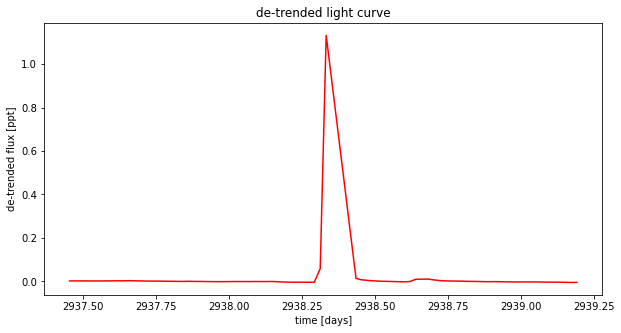

In [170]:
def normalize_flux(flux):
    return flux/np.median(flux) - 1
superflare = df.loc[1569:1655] # area around the superflare

plt.figure(figsize=(10, 5))
#detrended_superflare = superflare.PDCSAP_FLUX-np.ones(len(superflare))*np.median(superflare.PDCSAP_FLUX)
#detrended_superflare = normalize_flux(pd.concat([pre.PDCSAP_FLUX, post.PDCSAP_FLUX, postgap.PDCSAP_FLUX]))
detrended_superflare = normalize_flux(superflare.PDCSAP_FLUX)
plt.plot(superflare.TIME, detrended_superflare, "r")
#plt.plot(superflare.TIME[mask], superflare.PDCSAP_FLUX[mask], "k")
#plt.plot(pre.TIME, smooth)
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("de-trended light curve")
#plt.ylim(580000, 680000)
#plt.xlim(superflare.TIME.min(), superflare.TIME.max())
#plt.savefig('superflare.png')
plt.show()

In [171]:
print(detrended_superflare[39:42])
print(superflare.TIME[39:42])

1612    0.058684
1613    1.132200
1618    0.013559
Name: PDCSAP_FLUX, dtype: float32
1612    2938.313467
1613    2938.333899
1618    2938.436057
Name: TIME, dtype: float64


Hold up...so the superflare is just a single data point? Could this be a systematics/cosmic ray type situation? This introduces challenges with calculating the equivalent duration and therefore the flare's energy. 

In [172]:
superflare_ed = np.trapz(detrended_superflare[39:42], superflare.TIME[39:42]*86400)
print(superflare_ed)

6107.628352754084


### 5) Flare frequency distribution

In [173]:
superflare_ed = np.trapz(detrended_superflare[39:42], superflare.TIME[39:42]*86400)
print(superflare_ed)

6107.628352754084


The following cell contains equivalent duration calculations done before I saved off left and right bases using peak_prominences(), so I was fudging the bounds of the flare.

In [174]:
# get equivalent durations
ed_data = []
ed_model = []
ed_minus = []
ed_plus = []
for i in range(npeaks):
    timemask = (x >= tpeaks[i]-0.2) & (x < tpeaks[i]+0.2)
    ed_data.append(np.trapz(y[timemask]*86400, x[timemask]))
    ed_model.append(np.trapz(flc[1][timemask]*86400, x[timemask]))
    ed_minus.append(np.trapz(flc[0][timemask]*86400, x[timemask]))
    ed_plus.append(np.trapz(flc[2][timemask]*86400, x[timemask]))
    
print(ed_data)
print(ed_model)

# and multiply with quiescent luminosity to get flare energies

[37.62638821864314, 111.03222189106422, 28.30644630574195, 43.31743328892708, 44.9775883595825, 9.32945531424063, 32.62377745803883, -23.617313425827827, -6.940100200131982, 36.848135124210046, 36.848135124210046, 31.269534604769348, 49.19340964087556, 49.19340964087556, 28.18031414195874, 39.417319293039625, 8.927682749489504, 34.527765154126385, 19.001419004978107, 4.4875437074354805, 28.247864543653197, 28.247864543653197, 6.4482420063019275, 23.50601864625326, 32.698309081106736, 28.96190608621913, 42.69509198054419, 42.69509198054419, 45.19059886412205, 45.29616520101476, 53.41907857024062, 34.062967326181344, 37.66167186419693, 36.02236338812413, -10.285137298128012, -6.867226336049151, 3.7014498641511713]
[25.863176217367396, 136.9728763372934, 21.909658205596013, 59.76915727091301, 47.02650102697998, 8.550021817694638, 32.574156702013745, 13.7307981248176, 19.54009928081025, 33.82977711205835, 33.82977711205835, 28.13998228838499, 44.22337839748664, 44.22337839748664, 46.548003

This is EDs done using left and right bases from peak_prominences()

In [218]:
# get equivalent durations
ed_data = []
ed_model = []
ed_minus = []
ed_plus = []
for i in range(npeaks):
    timemask = (x >= flares_pre.left_bases[i]) & (x < flares_pre.right_bases[i])
    ed_data.append(np.trapz(y[timemask]*86400, x[timemask]))
    ed_model.append(np.trapz(flc[1][timemask]*86400, x[timemask]))
    ed_minus.append(np.trapz(flc[0][timemask]*86400, x[timemask]))
    ed_plus.append(np.trapz(flc[2][timemask]*86400, x[timemask]))
    
print(ed_data)
print(ed_model)
print(ed_minus)
print(ed_plus)

# and multiply with quiescent luminosity to get flare energies

[18.010043555040525, 92.01134082609022, 5.938406771744139, 30.960524875809014, 15.677150048813578, 4.284925836351881, 14.612689501981482, 8.099651623785082, 11.39767230494065, 16.715371968090267, 28.567131485605994, 20.105697131074535, 22.510038676774315, 29.589256060730598, 1.9209621279902702, 18.927757746149314, 4.780667677595611, 22.778164679531454, 8.503416604816733, 1.7443309577513826, 17.916690914680743, 19.686763561285485, 5.7389608997361545, 15.878472414915688, 12.331853934849656, 10.644087709280575, 20.472614164652867, 28.86608500592135, 36.171799820706234, 8.423574600992215, 16.103561170593906, 6.255884513346126, 23.36792743617587, 6.3163501048392385, 21.134051422605552, 9.772219537287086, 6.2421227228527165]
[17.288900326622905, 98.13238306829271, 5.3013283428876825, 33.80275464832428, 13.586225981959734, 5.401358152394034, 16.84231408810164, 13.70861954817152, 15.479309455374043, 19.194331769146398, 27.435804086909144, 19.85747128025915, 24.59592535514109, 31.97461027315186

In [219]:
def calculate_energy(kp, zeropoint, ed_model):
    l_sun = 3.0128e28 * 1e7 # Watts * 1e7 erg/s per Watt
    pre_lkp = l_sun * np.power(10, 0.4*(zeropoint-kp)) # https://iopscience.iop.org/article/10.1088/0004-637X/797/2/121/pdf
    print("log pre LKp: ", np.log10(pre_lkp)) # erg/(s*cm^2)
    lkp = (4*np.pi*distance**2) * pre_lkp * 4000
    print("log LKp: ", np.log10(lkp))
    print("ED: ", ed_model)
    try:
        return np.log10(lkp*ed_model)
    except:
        return np.log10([lkp*ed for ed in ed_model]) # show order of energy in ergs

# use kepmag value from exofop: https://exofop.ipac.caltech.edu/k2/edit_target.php?id=246301900
flare_energies = calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=ed_model)
flare_energies_minus = calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=ed_minus)
flare_energies_plus = calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=ed_plus)

# add the superflare
flare_energies = np.append(flare_energies, calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=superflare_ed))
flare_energies_minus = np.append(flare_energies_minus, calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=superflare_ed))
flare_energies_plus = np.append(flare_energies_plus, calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=superflare_ed))
print("log flare energy: ", np.sort(flare_energies))

log pre LKp:  23.060170302672592
log LKp:  31.09114643288431
ED:  [17.288900326622905, 98.13238306829271, 5.3013283428876825, 33.80275464832428, 13.586225981959734, 5.401358152394034, 16.84231408810164, 13.70861954817152, 15.479309455374043, 19.194331769146398, 27.435804086909144, 19.85747128025915, 24.59592535514109, 31.974610273151868, 9.435103347445914, 18.513726012757445, 4.869125561684589, 21.921741910160577, 8.367521313728611, 5.702743733781837, 10.593315765036943, 12.415483563043464, 4.233132005128148, 17.953582354379048, 9.437969029713873, 11.568967080464718, 20.19337511940506, 33.1249372887464, 25.628003166232748, 11.901082478912452, 16.55924287194178, 6.788450832160088, 34.16684071473268, 6.3148644196141, 20.87262740759156, 5.9654235478474815, 14.894548313690274]
log pre LKp:  23.060170302672592
log LKp:  31.09114643288431
ED:  [10.071787904335546, 91.45163737283788, 1.3212117078660024, 26.876200795852284, 8.29370929293184, 0.9244278426131858, 13.048523620918779, 9.3259282596

Do the same for post and postgap chunks

In [239]:
# get equivalent durations
ed_data_post = []
ed_model_post = []
ed_minus_post = []
ed_plus_post = []
for i in range(npeaks_post):
    timemask = (x_post >= flares_post.reset_index().left_bases[i]) & (x_post < flares_post.reset_index().right_bases[i])
    ed_data_post.append(np.trapz(y_post[timemask]*86400, x_post[timemask]))
    ed_model_post.append(np.trapz(flc_post[1][timemask]*86400, x_post[timemask]))
    ed_minus_post.append(np.trapz(flc_post[0][timemask]*86400, x_post[timemask]))
    ed_plus_post.append(np.trapz(flc_post[2][timemask]*86400, x_post[timemask]))
    
print(ed_data_post)
print(ed_model_post)
print(ed_minus_post)
print(ed_plus_post)

### Then multiply with quiescent luminosity to get flare energies
# use kepmag value from exofop: https://exofop.ipac.caltech.edu/k2/edit_target.php?id=246301900
flare_energies_post = calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=ed_model_post)
flare_energies_minus_post = calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=ed_minus_post)
flare_energies_plus_post = calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=ed_plus_post)

# add the superflare
flare_energies = np.append(flare_energies, flare_energies_post)
flare_energies_minus = np.append(flare_energies_minus, flare_energies_minus_post)
flare_energies_plus = np.append(flare_energies_plus, flare_energies_plus_post)
print("log flare energy: ", np.sort(flare_energies))

[29.401895730635108, 35.154736432283336, 52.460083258443326, 44.3415269744941, 23.513026498347713, 11.706676777703569, 31.041988925326606, 22.88660711190763, 27.615834207643, 13.644266706488022, 12.825799670889754, 29.291260604279554]
[27.258350023402436, 34.00841369964868, 59.107309973080454, 60.24159105430974, 11.956920352788067, 15.74151408938299, 30.36708736649676, 35.94791022286949, 40.4919117322898, 18.579404113034315, 13.362922905102403, 34.66488680548013]
[16.921018026337904, 18.563870499660794, 38.18591295183254, 44.4643925883806, 1.8104386656418097, 9.74590031764258, 12.290817435888462, 13.59422572018412, 25.705293795739497, 13.12569580068726, 8.750452704097308, 17.742959084286095]
[58.3212255061426, 75.25910144556939, 87.62425689999986, 90.68995846521284, 40.24107883250598, 28.81875918636309, 65.05114787906719, 65.94071008825561, 69.57723467085329, 32.24776824687325, 26.426981176756733, 65.28917624110392]
log pre LKp:  23.060170302672592
log LKp:  31.09114643288431
ED:  [27.

In [240]:
# get equivalent durations
ed_data_postgap = []
ed_model_postgap = []
ed_minus_postgap = []
ed_plus_postgap = []
for i in range(npeaks_postgap):
    timemask = (x_postgap >= flares_postgap.reset_index().left_bases[i]) & (x_postgap < flares_postgap.reset_index().right_bases[i])
    ed_data_postgap.append(np.trapz(y_postgap[timemask]*86400, x_postgap[timemask]))
    ed_model_postgap.append(np.trapz(flc_postgap[1][timemask]*86400, x_postgap[timemask]))
    ed_minus_postgap.append(np.trapz(flc_postgap[0][timemask]*86400, x_postgap[timemask]))
    ed_plus_postgap.append(np.trapz(flc_postgap[2][timemask]*86400, x_postgap[timemask]))
    
print(ed_data_postgap)
print(ed_model_postgap)
print(ed_minus_postgap)
print(ed_plus_postgap)

### Then multiply with quiescent luminosity to get flare energies
# use kepmag value from exofop: https://exofop.ipac.caltech.edu/k2/edit_target.php?id=246301900
flare_energies_postgap = calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=ed_model_postgap)
flare_energies_minus_postgap = calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=ed_minus_postgap)
flare_energies_plus_postgap = calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=ed_plus_postgap)

# add the superflare
flare_energies = np.append(flare_energies, flare_energies_postgap)
flare_energies_minus = np.append(flare_energies_minus, flare_energies_minus_postgap)
flare_energies_plus = np.append(flare_energies_plus, flare_energies_plus_postgap)
print("log flare energy: ", np.sort(flare_energies))

[12.029953982831664, 11.314156109639054, 5.2689933451136985, 7.663127847539202, 3.5331154275283, 7.646829889789052, 2.8978445276715514, 8.813905693576725, 16.24272876530556, 12.76893370758711, 20.922715355789485, 8.540882840098293, 12.11340097774595, 15.81150375843463, 8.957258547255362, 4.587720737997007, 5.3811501073112, 18.787568566970034]
[11.092682566599581, 7.718808840145993, 9.116286538571607, 5.311457051419369, 3.6406842414622638, 4.256961062084452, 4.498708978430911, 3.6737724407770482, 15.43397752266308, 7.239899321635742, 28.615685846449963, 7.408008156301099, 9.886620959266438, 11.505626940718777, 7.747379266760559, 3.7778536160282252, 4.386957397123234, 16.479280898668023]
[6.0391267878455945, 2.6805254738551074, 3.7091131198938068, 1.9708236990105705, 0.9219308786233555, 1.0050939115205704, 3.5446014391132374, 1.0340788954595475, 10.245924233486537, 4.091755795075111, 27.66592358510258, 3.2954757365877514, 4.277448922820044, 4.457561542944957, 4.448991265175112, 1.3222299

Plot FFD

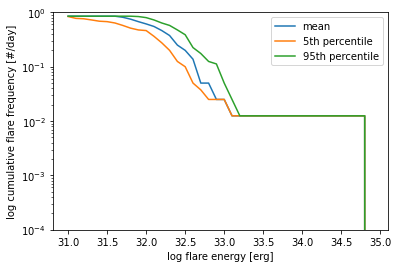

In [243]:
hist, edges = np.histogram(flare_energies, bins=np.linspace(31.0, 35.0, 41))
hist_minus, edges_minus = np.histogram(flare_energies_minus, bins=np.linspace(31.0, 35.0, 41))
hist_plus, edges_plus = np.histogram(flare_energies_plus, bins=np.linspace(31.0, 35.0, 41))

#plt.scatter(edges[:-1], np.log10(hist/80)) # divided by time series length of 80 days
#plt.scatter(edges[:-1], np.log10(np.cumsum(hist[::-1])[::-1]/80)) # cumulative sum; invert order b/c they count from highest bin
#plt.scatter(edges_minus[:-1], np.log10(np.cumsum(hist_minus[::-1])[::-1]/80), marker='v') # cumulative sum; invert order b/c they count from highest bin
#plt.scatter(edges_plus[:-1], np.log10(np.cumsum(hist_plus[::-1])[::-1]/80), marker='^') # cumulative sum; invert order b/c they count from highest bin
#plt.plot(edges[:-1], np.log10(np.cumsum(hist[::-1])[::-1]/80), label='mean') # cumulative sum; invert order b/c they count from highest bin
#plt.plot(edges_minus[:-1], np.log10(np.cumsum(hist_minus[::-1])[::-1]/80), label='5th percentile') # cumulative sum; invert order b/c they count from highest bin
#plt.plot(edges_plus[:-1], np.log10(np.cumsum(hist_plus[::-1])[::-1]/80), label='95th percentile') # cumulative sum; invert order b/c they count from highest bin
plt.plot(edges[:-1], np.cumsum(hist[::-1])[::-1]/80, label='mean') # cumulative sum; invert order b/c they count from highest bin
plt.plot(edges_minus[:-1], np.cumsum(hist_minus[::-1])[::-1]/80, label='5th percentile') # cumulative sum; invert order b/c they count from highest bin
plt.plot(edges_plus[:-1], np.cumsum(hist_plus[::-1])[::-1]/80, label='95th percentile') # cumulative sum; invert order b/c they count from highest bin
plt.ylabel('log cumulative flare frequency [#/day]')
plt.xlabel('log flare energy [erg]')
plt.legend()
plt.yscale('log')
plt.ylim(1e-4, 1e0)
plt.savefig('ffd.png', bbox_inches='tight', format='png')
plt.show()

In [250]:
len(flares_pre)+len(flares_post)+len(flares_postgap)

67

#### Incorporate errors in stellar properties